In [1]:
import functools
import random
import typing as t
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

In [3]:
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)

seed_everything(42)

In [21]:
COMBINED_DIR = Path('/home/jovyan/jigsaw-toxic/data/datasets/combined')
MULTILABEL_DIR = Path('/home/jovyan/jigsaw-toxic/data/datasets/ccc-2017-multilabel')
DATASET_DIR = Path('/home/jovyan/jigsaw-toxic/data/datasets/ccc-2017-regression')

In [23]:
!mkdir -p $DATASET_DIR
!cp $COMBINED_DIR/valid.csv $DATASET_DIR/valid.csv

In [5]:
all_df = t.cast(pd.DataFrame, pd.read_csv(DATASET_DIR / 'train_no_leak.csv'))

In [6]:
def generate_score_for_row(
        row: t.Dict[str, int],
        toxic_weight: float = 1.0,
        severe_toxic_weight: float = 2.5,
        obscene_weight: float = 1.0,
        threat_weight: float = 1.0,
        insult_weight: float = 1.0,
        identity_hate_weight: float = 1.0) -> float:
    score = row['toxic'] * toxic_weight + \
        row['severe_toxic'] * severe_toxic_weight + \
        row['obscene'] * obscene_weight + \
        row['threat'] * threat_weight + \
        row['insult'] * insult_weight + \
        row['identity_hate'] * identity_hate_weight
    return score / (
        toxic_weight + 
        severe_toxic_weight + 
        obscene_weight + 
        threat_weight + 
        insult_weight + 
        identity_hate_weight)

In [7]:
all_df['score'] = all_df.progress_apply(
    functools.partial(
        generate_score_for_row,
        toxic_weight=0.32,
        severe_toxic_weight=1.5,
        obscene_weight=0.16,
        insult_weight=0.64,
        threat_weight=1.5,
        identity_hate_weight=1.5),
    axis=1)

  0%|          | 0/151942 [00:00<?, ?it/s]

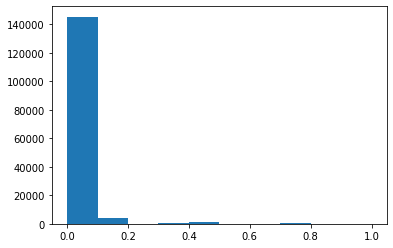

In [9]:
plt.hist(all_df['score']);

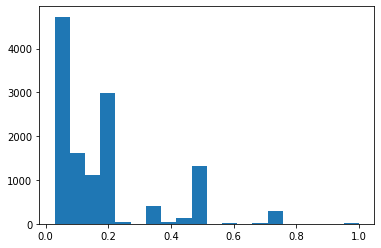

In [12]:
plt.hist(all_df[all_df['score'] > 0.0]['score'], bins=20);

In [13]:
toxic_train_df = all_df[all_df['score'] > 0.0]
non_toxic_train_df = all_df[all_df['score'] == 0.0].sample(n=int(len(toxic_train_df) * 0.25))
train_df = pd.concat([toxic_train_df, non_toxic_train_df]).reset_index(drop=True)

In [15]:
train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,score
0,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,0.056940
1,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,0.056940
2,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,0.466192
3,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,1,0,0,0,0,0,0.056940
4,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,0.085409
...,...,...,...,...,...,...,...,...,...
15913,5231f743be85e2e9,"""Unnecessary unblock request ==\n{{unblock-ip|...",0,0,0,0,0,0,0.000000
15914,72659ecf999a06df,"Oh, and another thing. That section about mail...",0,0,0,0,0,0,0.000000
15915,f1c8b43b5060d052,Does not allow for faster-than-light communica...,0,0,0,0,0,0,0.000000
15916,dab9ec6680fd659b,The sock (a sock?) has been blocked now - see . -,0,0,0,0,0,0,0.000000


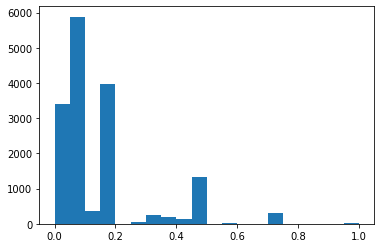

In [25]:
plt.hist(train_df['score'], bins=20);

In [26]:
train_df.to_csv(DATASET_DIR / 'train.csv', index=False)

In [28]:
!ls -la $DATASET_DIR

total 14032
drwxr-xr-x  2 jovyan users    4096 Feb  3 20:53 .
drwxr-xr-x 12 jovyan users    4096 Feb  3 20:48 ..
-rw-r--r--  1 jovyan users 5725706 Feb  3 20:53 train.csv
-rw-r--r--  1 jovyan users 8633656 Feb  3 20:49 valid.csv
